Notebook where I use least-squares optimisation to fit bi-exponential functions to exciton decay plots. The bi-exponential decay originates from the assumption that the initial population of excitons can be split into two non-overlapping sections: one initialised near the interface and one further from the interface such that immediate dissociation is unlikely. This allows you to express the total population as a sum of the populations of these two sections, with each population showing linear decay. Each time-dependent sector population can be described by an independent ODE, which can be solved to give the sector population as an exponential. The total population is then a sum of these two exponential terms.

In [1]:
import numpy as np
import scipy.optimize as scopt
import matplotlib.pyplot as plt
from fitting_tools import *

/usr/lib64/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [20]:
def block_statistics(observable_array, number_blocks):
    
    block_means = np.zeros((number_blocks, len(observable_array[0])))

    number_trajectories = len(observable_array)
    trajectories_per_block = number_trajectories//number_blocks

    for block_index in range(number_blocks):
        block_means[block_index, :] = np.mean(observable_array[block_index*trajectories_per_block: block_index*trajectories_per_block + trajectories_per_block,:] ,axis = 0)

    final_block_mean = np.mean(block_means, axis = 0)
    final_block_sd = np.std(block_means, axis = 0)

    return final_block_mean, final_block_sd

In [28]:
folder_name = 'epsilon5_3xCTcoup'
file_tag = 'e5_3xCT'
nuclear_timestep = 0.05

In [29]:
total_XT_single_populations = np.loadtxt(f'/scratch/fivanovic/X-SH/T6-PDI/production_runs/{folder_name}/analysis_arrays/{file_tag}_XT_individual_populations.txt')
XT_avg, XT_sd = block_statistics(total_XT_single_populations, 5)
simulation_time = np.arange(len(XT_avg))*10*nuclear_timestep/1000

0.0015376689379413531
XT-pop variance 0.0015795327288769916


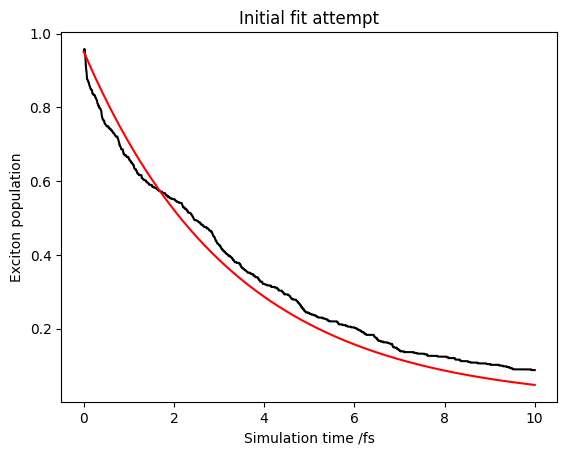

In [30]:
#guess = [2, 0.09, 5.5]
#initial guess of fast, slow decay constants and slow-fast decay ratio, slow-fast decay ratio should always be > 1 since excitons are initialised in a gaussian-like
#distribution, and should not vary too much between different parameter sets

#guess = [6, 2, 0.21, 2.5, 5]
#initial guess of decay constants and expansion coefficients for tri-exp model in the order: fast decay constant, medium decay constant, slow decay constant, medium-fast ratio, slow-fast ratio

guess = [0.3]
#initial guess of decay constant of mono-exponential decay function

plt.plot(simulation_time, XT_avg, color = 'k', label = 'X-SH')
plt.plot(simulation_time, mexp_exciton_decay(simulation_time, XT_avg[0], guess), color = 'r', label = 'Least-squares fit')
plt.xlabel('Simulation time /fs')
plt.ylabel('Exciton population')
plt.title('Initial fit attempt')

initial_residuals = residual(guess, simulation_time, XT_avg, mexp_exciton_decay)
initial_cost = np.sum(initial_residuals**2)/len(simulation_time)
#getting the initial cost; varying the initial guess parameters until initial guess cost is smaller than the total variance of the exciton population
print(initial_cost)
print('XT-pop variance', np.mean(XT_sd**2))

In [31]:
#carrying out the least-squares fit using scipy optimise module, no initial jacobian, tolerances all set to default vals, method is default and is good generally, no bounds used
fit = scopt.least_squares(residual, guess, args = (simulation_time, XT_avg, mexp_exciton_decay), method='trf')
opt_parameters = fit.x
print(opt_parameters)

[0.2701843]


Text(0.5, 1.0, 'Least-squares fit')

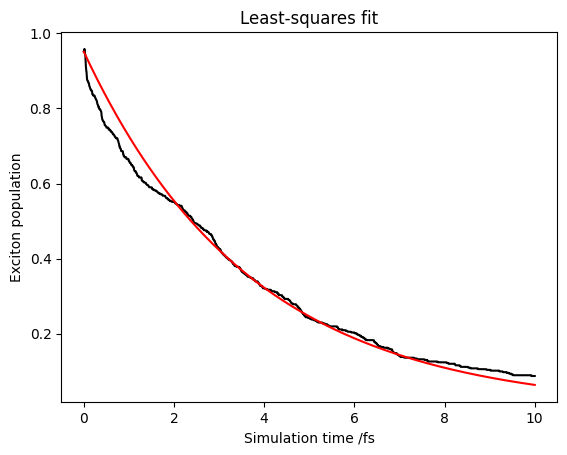

In [32]:
plt.plot(simulation_time, XT_avg, color = 'k', label = 'X-SH')
plt.plot(simulation_time, mexp_exciton_decay(simulation_time, XT_avg[0] , opt_parameters), color = 'r', label = 'Least-squares fit')
plt.xlabel('Simulation time /fs')
plt.ylabel('Exciton population')
plt.title('Least-squares fit')

In [33]:
#the use of a coefficient ratio instead of explicit coefficient value ensures that the initial modelled population is equal to data at t=0, as the
#coeff vals are obtained using the ratio and initial population, as shown above
print(XT_avg[0] - mexp_exciton_decay(simulation_time, XT_avg[0] ,opt_parameters)[0])

0.0


In [34]:
ssq = fit.cost*2/len(simulation_time)
RMSE = np.sqrt(ssq/len(XT_avg))
RSE = np.sqrt(ssq/(len(XT_avg)-len(guess)))

#checking here that the cost (half ssq) is reduced wrt initial guess, and that it's lower than exciton population variance
print('Guess cost:', initial_cost)
print('Fit cost:', ssq)
print('XT-pop variance:', np.mean(XT_sd**2))
print('RMSE:', RMSE)
print('Residual standard error:', RSE)

# result array elements: fast_coeff, fast_decay, slow_coeff, slow_decay, ssq of guess, ssq of fit, variance of XT-populations

result_array = np.hstack((opt_parameters, np.array([initial_cost, fit.cost*2/len(simulation_time), np.mean(XT_sd**2), RMSE, RSE])))
np.savetxt(f'{file_tag}-fit.txt', result_array)

Guess cost: 0.0015376689379413531
Fit cost: 0.0007651353389492602
XT-pop variance: 0.0015795327288769916
RMSE: 0.00019558848177935422
Residual standard error: 0.00019559337143027882


In [2]:
exp_keyword = 'mexp'

physopt_mexp_parameters = np.loadtxt(f'{exp_keyword}_fits/physopt_retry-fit.txt')
e3p5_2xCT_mexp_parameters = np.loadtxt(f'{exp_keyword}_fits/e3.5_2xCT-fit.txt')
e5_mexp_parameters = np.loadtxt(f'{exp_keyword}_fits/e5-fit.txt')
e3p5_3xCT_mexp_parameters = np.loadtxt(f'{exp_keyword}_fits/e3.5_3xCT-fit.txt')
e5_2xCT_mexp_parameters = np.loadtxt(f'{exp_keyword}_fits/e5_2xCT-fit.txt')
e5_3xCT_mexp_parameters = np.loadtxt(f'{exp_keyword}_fits/e5_3xCT-fit.txt')
e10_mexp_parameters = np.loadtxt(f'{exp_keyword}_fits/e10-fit.txt')

exp_keyword = 'biexp'

physopt_biexp_parameters = np.loadtxt(f'{exp_keyword}_fits/physopt_retry-fit.txt')
e3p5_2xCT_biexp_parameters = np.loadtxt(f'{exp_keyword}_fits/e3.5_2xCT-fit.txt')
e5_biexp_parameters = np.loadtxt(f'{exp_keyword}_fits/e5-fit.txt')
e3p5_3xCT_biexp_parameters = np.loadtxt(f'{exp_keyword}_fits/e3.5_3xCT-fit.txt')
e5_2xCT_biexp_parameters = np.loadtxt(f'{exp_keyword}_fits/e5_2xCT-fit.txt')
e5_3xCT_biexp_parameters = np.loadtxt(f'{exp_keyword}_fits/e5_3xCT-fit.txt')
e10_biexp_parameters = np.loadtxt(f'{exp_keyword}_fits/e10-fit.txt')

exp_keyword = 'triexp'

physopt_triexp_parameters = np.loadtxt(f'{exp_keyword}_fits/physopt_retry-fit.txt')
e3p5_2xCT_triexp_parameters = np.loadtxt(f'{exp_keyword}_fits/e3.5_2xCT-fit.txt')
e5_triexp_parameters = np.loadtxt(f'{exp_keyword}_fits/e5-fit.txt')
e3p5_3xCT_triexp_parameters = np.loadtxt(f'{exp_keyword}_fits/e3.5_3xCT-fit.txt')
e5_2xCT_triexp_parameters = np.loadtxt(f'{exp_keyword}_fits/e5_2xCT-fit.txt')
e5_3xCT_triexp_parameters = np.loadtxt(f'{exp_keyword}_fits/e5_3xCT-fit.txt')
e10_triexp_parameters = np.loadtxt(f'{exp_keyword}_fits/e10-fit.txt')

mexp_parameter_list = [physopt_mexp_parameters, e3p5_2xCT_mexp_parameters, e3p5_3xCT_mexp_parameters, e5_mexp_parameters, e5_2xCT_mexp_parameters, e5_3xCT_mexp_parameters, e10_mexp_parameters]
biexp_parameter_list = [physopt_biexp_parameters, e3p5_2xCT_biexp_parameters, e3p5_3xCT_biexp_parameters, e5_biexp_parameters, e5_2xCT_biexp_parameters, e5_3xCT_biexp_parameters, e10_biexp_parameters]
triexp_parameter_list = [physopt_triexp_parameters, e3p5_2xCT_triexp_parameters, e3p5_3xCT_triexp_parameters, e5_triexp_parameters, e5_2xCT_triexp_parameters, e5_3xCT_triexp_parameters, e10_triexp_parameters]

In [3]:
def get_r2_vals(tag, p_init, mexp_parameters, biexp_parameters, triexp_parameters):

    data = np.loadtxt(f'/scratch/fivanovic/X-SH/T6-PDI/production_runs/saved_wf_processing/average_populations/{tag}_avg_XT.txt')

    mexp_fit_data = mexp_exciton_decay(np.arange(len(data))*10*0.05/1000, p_init, mexp_parameters)
    biexp_fit_data = biexp_exciton_decay(np.arange(len(data))*10*0.05/1000, p_init, biexp_parameters)
    triexp_fit_data = triexp_exciton_decay(np.arange(len(data))*10*0.05/1000, p_init, triexp_parameters)

    fit_data_list = [mexp_fit_data, biexp_fit_data, triexp_fit_data]
    fit_r2_vals = []

    for fit_data in fit_data_list:
        ssq = np.sum((data - fit_data)**2)

        mean_data = np.mean(data)
        tss = np.sum((data - mean_data)**2)

        r2 = 1 - ssq/tss
        fit_r2_vals.append(r2)

    return fit_r2_vals

In [4]:
sim_tags = ['physopt_retry', 'e3.5_2xCT', 'e3.5_3xCT', 'e5', 'e5_2xCT', 'e5_3xCT', 'e10']
initial_exciton_populations = [0.969, 0.959, 0.989, 0.955, 0.941, 0.959, 0.951]

r2_all_sims = np.zeros((7,3))

for j in range(len(sim_tags)):
    tag = sim_tags[j]
    p_init = initial_exciton_populations[j]

    r2_vals = get_r2_vals(tag, p_init, mexp_parameter_list[j], biexp_parameter_list[j], triexp_parameter_list[j])
    r2_all_sims[j] = r2_vals

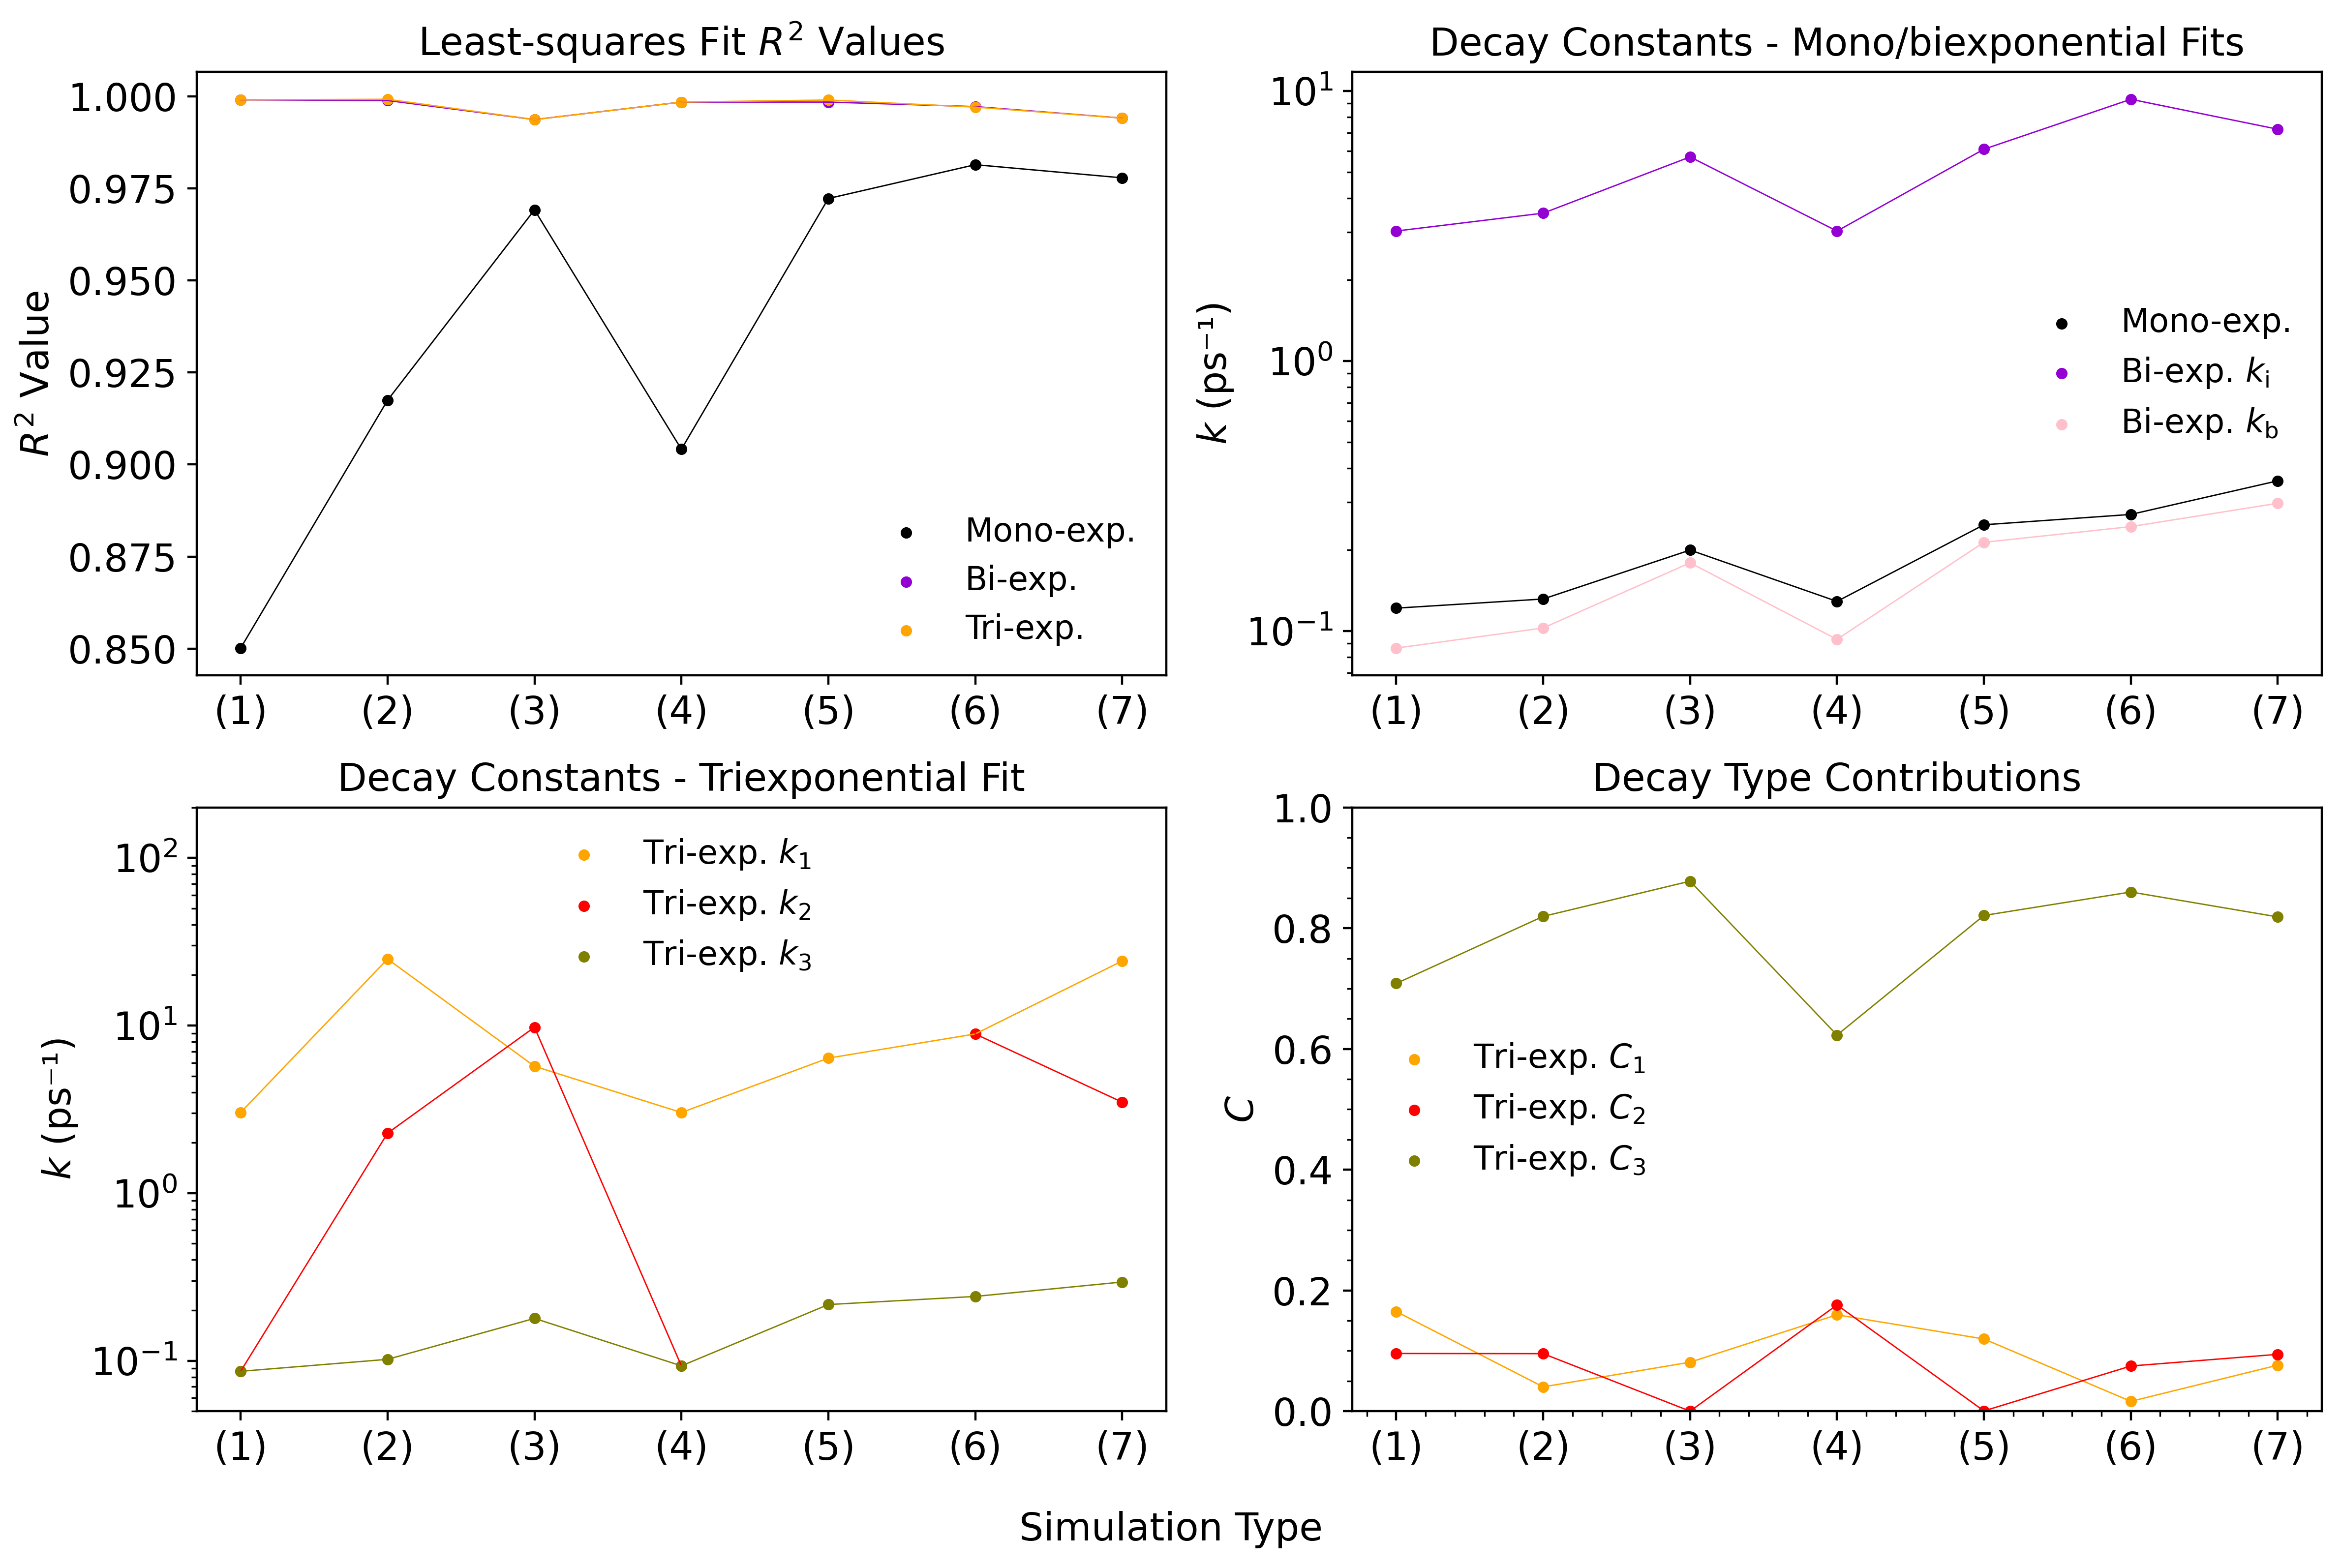

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,8), rasterized=True, dpi=400)

simulation_list = ['(1)', '(2)', '(3)', '(4)', '(5)', '(6)', '(7)']
initial_exciton_populations = np.array([0.969, 0.955, 0.959, 0.9585, 0.941, 0.951, 0.989])

mexp_rmse = [l[-2] for l in mexp_parameter_list]
biexp_rmse = [l[-2] for l in biexp_parameter_list]
triexp_rmse = [l[-2] for l in triexp_parameter_list]

mexp_r2 = r2_all_sims[:,0]
biexp_r2 = r2_all_sims[:,1]
triexp_r2 = r2_all_sims[:,2]

mexp_k = [l[0] for l in mexp_parameter_list]
biexp_k1 = [l[0] for l in biexp_parameter_list]
biexp_k2 = [l[1] for l in biexp_parameter_list]
biexp_coeff_ratio = [l[2] for l in biexp_parameter_list]
biexp_fast_c, biexp_slow_c = get_biexp_coeffs(np.array(biexp_coeff_ratio), initial_exciton_populations)

triexp_k1 = [l[0] for l in triexp_parameter_list]
triexp_k2 = [l[1] for l in triexp_parameter_list]
triexp_k3 = [l[2] for l in triexp_parameter_list]
triexp_12_ratio = [l[3] for l in triexp_parameter_list]
triexp_13_ratio = [l[4] for l in triexp_parameter_list]
triexp_c1, triexp_c2, triexp_c3 = get_triexp_coeffs(np.array(triexp_12_ratio), np.array(triexp_13_ratio), initial_exciton_populations)

triexp_k2[4], triexp_k3[4] = triexp_k3[4], triexp_k2[4]
triexp_c2[4], triexp_c3[4] = triexp_c3[4], triexp_c2[4] #switching these coeffs around bc the graph looks better, we therefore switch around the 
#decay constants as well so they remain consistent

axs[0,0].scatter(simulation_list, mexp_r2, color='k', s=10, label='Mono-exp.')
axs[0,0].plot(simulation_list, mexp_r2, color='k', linewidth=0.5)
axs[0,0].scatter(simulation_list, biexp_r2, color='darkviolet', s=10, label='Bi-exp.')
axs[0,0].plot(simulation_list, biexp_r2, color='darkviolet', linewidth=0.5)
axs[0,0].scatter(simulation_list, triexp_r2, color='orange', s=10, label='Tri-exp.')
axs[0,0].plot(simulation_list, triexp_r2, color='orange', linewidth=0.5)
axs[0,0].set_ylabel('$R^{2}$ Value', fontsize=14)
axs[0,0].yaxis.set_tick_params(labelsize = 14)
axs[0,0].xaxis.set_tick_params(labelsize = 14)
axs[0,0].set_title('Least-squares Fit $R^{2}$ Values', fontsize=14)
axs[0,0].legend(loc='lower right', fontsize=12, frameon=False)

axs[0,1].scatter(simulation_list, mexp_k, color='k', s=10, label='Mono-exp.')
axs[0,1].plot(simulation_list, mexp_k, color='k', linewidth=0.5)
axs[0,1].scatter(simulation_list, biexp_k1, color='darkviolet', s=10, label=r'Bi-exp. $k_{\mathrm{i}}$')
axs[0,1].plot(simulation_list, biexp_k1, color='darkviolet', linewidth=0.5)
axs[0,1].scatter(simulation_list, biexp_k2, color='pink', s=10, label=r'Bi-exp. $k_{\mathrm{b}}$')
axs[0,1].plot(simulation_list, biexp_k2, color='pink', linewidth=0.5)
axs[0,1].set_yscale('log')
axs[0,1].set_ylabel('$k$ (ps\u207B\u00B9)', fontsize=14)
axs[0,1].yaxis.set_tick_params(labelsize = 14)
axs[0,1].xaxis.set_tick_params(labelsize = 14)
axs[0,1].set_title('Decay Constants - Mono/biexponential Fits', fontsize=14)
axs[0,1].legend(loc='center right', fontsize=12, frameon=False)

axs[1,0].scatter(simulation_list, triexp_k1, color='orange', s=10, label=r'Tri-exp. $k_\mathrm{1}$')
axs[1,0].plot(simulation_list, triexp_k1, color='orange', linewidth=0.5)
axs[1,0].scatter(simulation_list[:4], triexp_k2[:4], color='red', s=10)
axs[1,0].plot(simulation_list[:4], triexp_k2[:4], color='red', linewidth=0.5)
axs[1,0].scatter(simulation_list[5:], triexp_k2[5:], color='red', s=10, label=r'Tri-exp. $k_\mathrm{2}$')
axs[1,0].plot(simulation_list[5:], triexp_k2[5:], color='red', linewidth=0.5)
axs[1,0].scatter(simulation_list, triexp_k3, color='olive', s=10, label=r'Tri-exp. $k_\mathrm{3}$')
axs[1,0].plot(simulation_list, triexp_k3, color='olive', linewidth=0.5)
axs[1,0].set_yscale('log')
axs[1,0].set_ylabel('$k$ (ps\u207B\u00B9)', fontsize=14)
axs[1,0].yaxis.set_tick_params(labelsize = 14)
axs[1,0].xaxis.set_tick_params(labelsize = 14)
axs[1,0].set_title('Decay Constants - Triexponential Fit', fontsize=14)
axs[1,0].legend(loc='upper center', fontsize=12, frameon=False)
axs[1,0].set_ylim([0.05,200])

axs[1,1].scatter(simulation_list, triexp_c1, color='orange', s=10, label=r'Tri-exp. $C_\mathrm{1}$')
axs[1,1].plot(simulation_list, triexp_c1, color='orange', linewidth=0.5)
axs[1,1].scatter(simulation_list, triexp_c2, color='red', s=10, label=r'Tri-exp. $C_\mathrm{2}$')
axs[1,1].plot(simulation_list, triexp_c2, color='red', linewidth=0.5)
axs[1,1].scatter(simulation_list, triexp_c3, color='olive', s=10, label=r'Tri-exp. $C_\mathrm{3}$')
axs[1,1].plot(simulation_list, triexp_c3, color='olive', linewidth=0.5)
axs[1,1].set_ylabel('$C$', fontsize=14)
axs[1,1].yaxis.set_tick_params(labelsize = 14)
axs[1,1].xaxis.set_tick_params(labelsize = 14)
axs[1,1].set_title('Decay Type Contributions', fontsize=14)
axs[1,1].legend(loc='center left', fontsize=12, frameon=False)
axs[1,1].set_ylim([0,1])
axs[1,1].minorticks_on()

fig.supxlabel('Simulation Type', fontsize=14)
fig.tight_layout()